# Libraries


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import datetime
import json
%matplotlib inline

#text processing
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize
import nltk
from nltk.corpus import stopwords

#sentiment
from textblob import TextBlob

#LDA model
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim



# 1. Introduction

In this project, our aim is to implement a number of machine learning models to answer  our research question on the AI Tools  dataset.

- Research Question: Which predictors and criterion contribute to a good predictive model for AI tool success?

During this thesis project we consolidate the knowledge by building a variety of machine learning models independently.

-----------------------------------------------------------------------------------------------------


**In this section the aim is to create an LDA model. The following process will be taken:**

1. Cleaning the review text

2. Splitting by tool_id

3. Splitting reviews with interpunction (a dot).

4. Determine topics by LDA

5. Determine if topic is in sentence based on LDA model

6. Determine sentiment per sentence

7. Determine average amount of topic N mentioned per tool

8. Determine sentiment per topic by averaging the sentiment times the weighted average of topics per tool

# 2. Prelimenary Data Exploration

A lot of data has been gathered with a lot of features. For the research the features that will be analyzed will be selected.

In [17]:
# Laden van de dataset
file_path1 = '/Users/macbook/thesis/new/code/data/processed_data/final.csv'
file_path2 = '/Users/macbook/thesis/new/code/data/processed_data/reviews_data.csv'

#general information on tools
gen = pd.read_csv(file_path1)

#review data
rev = pd.read_csv(file_path2)


/var/folders/lz/910twyk903nb6sxfgz54bngc0000gn/T/ipykernel_24702/1714893796.py:5: DtypeWarning: Columns (13,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  gen = pd.read_csv(file_path1)


In [19]:
rev = rev.dropna()

In [20]:
rev.shape

(24117, 13)

In [21]:
rev.sample(5)

,tool_id,review_id,review_text,review_date,user_info_name,user_info,helpful_count,all_time_score,amount_of_reviews,tool_link,recent_review_score,recent_reviews_amount,url_format
27340,1776.0,review-659034,I like the features this offers,2023-08-14T20:39:52-07:00,Jam Perry,/@jameson_perry,1,4.4,32.0,https://founderpal.ai/user-persona-generator?r...,5.0,3.0,founderpal.ai
34184,3406.0,review-668138,This is an amazing product. While there are a ...,2023-08-31T08:51:19-07:00,Harshdip Singh Deogan,/@harshdip,1,5.0,117.0,https://ioni.ai?ref=producthunt,5.0,117.0,ioni.ai
41721,7856.0,review-614458,What I love most about Roketfy is its user-fri...,2023-05-10T07:21:24-07:00,Yucel F. Sahan,/@yucelfaruksahan,0,5.0,38.0,https://roketfy.com/product-hunt?ref=producthunt,1.0,0.0,roketfy.com
42136,9926.0,review-663512,This is the best app. I am using it. It helps ...,2023-08-22T22:26:54-07:00,Brijesh Rao,/@brijesh_rao,0,4.7,330.0,https://ezml.io?ref=producthunt,4.8,200.0,ezml.io
1826,6900.0,review-571936,Great Product. Amazing Features.,2023-01-31T02:08:23-08:00,Armando Hysenaj,/@armando_hysenaj1,0,4.7,14.0,https://quinv.io/ai?ref=producthunt,1.0,0.0,quinv.io


# 3. Latent Dirichlet Allocation

#### **All LDA sections are retrieved from https://nicharuc.github.io/topic_modeling/.**



### Data normalizing

In [8]:
rev.dtypes

tool_id                  float64
review_id                 object
review_text               object
review_date               object
user_info_name            object
user_info                 object
helpful_count              int64
all_time_score           float64
amount_of_reviews        float64
tool_link                 object
recent_review_score      float64
recent_reviews_amount    float64
url_format                object
dtype: object

In [22]:
#code retrieved from ChatGPT (2024)

#review text to string
rev['review_text'] = rev['review_text'].astype(str)

# split review in seperate sentences
rows = []
for _, row in rev.iterrows():
    for sentence in sent_tokenize(row['review_text']):
        rows.append({'tool_id': row['tool_id'], 'review_id': row['review_id'], 'sentence': sentence})

sentence_df = pd.DataFrame(rows)


In [39]:
sentence_df.shape

(58187, 3)

In [24]:
sentence_df.head()

,tool_id,review_id,sentence
0,5780.0,review-583075,It's very practical and easy to follow guide.
1,5780.0,review-583075,Explains the basics and every component used i...
2,5780.0,review-583075,Written in easy to understand language.
3,5780.0,review-583075,"Great to start your journey with ""digital assi..."
4,5780.0,review-583075,Great work 🤙


In [46]:
#code retrieved from ChatGPT (2024)

def clean_text(text):
    # Verwijder alles behalve alfabetische tekens en zet om naar lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    #keep only words
    text = re.sub(r'\b\w{1,3}\b', '', text)
    
    words = text.split()

    return ' '.join(words)

def clean_all(df, column_name):
    rev[column_name] = rev[column_name].apply(clean_text)
    return df

# Aanname: 'df' is je oorspronkelijke DataFrame
selected_columns = ['review_text' , 'tool_id', 'review_id']
selected_df = rev[selected_columns]

cleaned_df = clean_all(selected_df, 'review_text')


In [41]:
cleaned_df.dtypes

review_text     object
tool_id        float64
review_id       object
dtype: object

In [43]:
cleaned_df['review_text'] = cleaned_df['review_text'].map(str)


/var/folders/lz/910twyk903nb6sxfgz54bngc0000gn/T/ipykernel_24702/805084263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['review_text'] = cleaned_df['review_text'].map(str)


In [44]:
cleaned_df.shape

(24117, 3)

In [47]:
cleaned_df.head()

,review_text,tool_id,review_id
2,very practical easy follow guide explains basi...,5780.0,review-583075
3,mind blowing what done with code,5780.0,review-583975
4,easy used listens simple instructions very int...,5780.0,review-615370
5,fantastic piece work,5780.0,review-581656
6,this another wrapper does have model,913.0,review-668680


## Pre-Processing steps including text cleaning and POS tagging

In [48]:
#delete rows with empty review text
cleaned_df = cleaned_df[cleaned_df['review_text'] != '']

#delete rows with 1 word
cleaned_df = cleaned_df[cleaned_df['review_text'].str.split().str.len() > 2]

In [49]:

# bigram and trigram analysis
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([review.split() for review in cleaned_df['review_text']])
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in cleaned_df['review_text']])

# Filter only those that occur at least 20 times
finder.apply_freq_filter(20)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [50]:
# Create dataframes for bigram 
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

# Create dataframes for trigram 
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [51]:
# stop word list
stop_word_list = stopwords.words("english")
stop_word_list.extend(['me', 'it' , 'for' , 'yelp', 'james' , 'raycast', 'slack',  'figma' ,'wizard', 'notion', 'zoom', 'twitter', 'loom', 'b', 'rocket', 'nan', 'wizardjamesrecovery' ,'www', 'https', 'google', 'com', 'http', 'wizardjames', 'gmail', 'whatsapp'])

In [52]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True
    
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [53]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 100 ngrams that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:100]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:100]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [54]:
# showing bigrams
bigrams[:150]


['ibolt cyber',
 'deepbrain studios',
 'stable diffusion',
 'third party',
 'cutting edge',
 'drag drop',
 'opus clip',
 'artificial intelligence',
 'wide range',
 'cyber hacker',
 'early adopter',
 'action items',
 'mind blowing',
 'learning curve',
 'chrome extension',
 'computer vision',
 'target audience',
 'recovery agent',
 'landing page',
 'knowledge base',
 'long term',
 'search engines',
 'back forth',
 'open source',
 'note taking',
 'daily basis',
 'natural language',
 'landing pages',
 'lead generation',
 'machine learning',
 'early stage',
 'social media',
 'customization options',
 'search engine',
 'blog posts',
 'keyword research',
 'daily routine',
 'cost effective',
 'video conferencing',
 'game changer',
 'high quality',
 'anyone wants',
 'anything else',
 'nothing short',
 'next level',
 'image generator',
 'free trial',
 'boost productivity',
 'free tier',
 'anyone seeking',
 'last year',
 'long form',
 'task management',
 'past months',
 'small businesses',
 'earl

In [56]:
# showing trigrams
trigrams[:20]

['ibolt cyber hacker',
 'drag drop interface',
 'social media posts',
 'absolute game changer',
 'total game changer',
 'highly recommend giving',
 'user friendly interface',
 'huge time saver',
 'life much easier',
 'makes life easier',
 'game changer anyone',
 'game changer world',
 'saved much time',
 'intuitive user friendly',
 'saves much time',
 'keep good work',
 'like game changer',
 'tool anyone looking',
 'keep great work',
 'tool game changer']

In [57]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [58]:
reviews_w_ngrams = cleaned_df.copy()

In [59]:
# replace 
reviews_w_ngrams.review_text = reviews_w_ngrams.review_text.map(lambda x: replace_ngram(x))

In [60]:
# Tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.review_text.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and len(word) > 1])

In [61]:
# Filter for only nouns (or nouns and verbs)
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [62]:
final_reviews = reviews_w_ngrams.map(noun_only)

In [63]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(final_reviews)

# Filter out words that occur in less than 20 documents, or more than 10% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.9)

In [64]:
# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in final_reviews]

In [65]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1310
Number of documents: 19606


## Determining amount of topics on coherence score

In [66]:
# setting training parameters
topics = [5, 10, 11, 12, 13, 14, 15,16, 17, 18, 19, 20, 25, 30]
coherence = []
for k in topics:
    print('Round: '+str(k))
    # using multicore to speed up the process
    Lda = gensim.models.ldamulticore.LdaMulticore
    ldamodel = Lda(corpus, num_topics=k, workers= 8, id2word = dictionary, passes=1,\
                   iterations=100, eval_every = None)
    # Compute Coherence Score
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))


Round: 5


Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 25
Round: 30


In [67]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

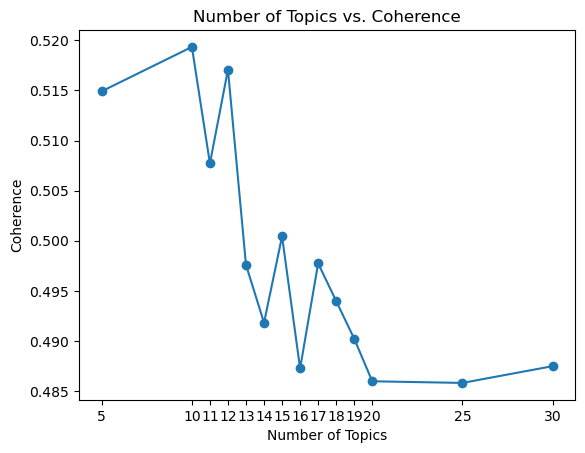

In [68]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

## Hyperparameter tuning

In [72]:
# hyperparameter tuning
# normally more passes and iterations are better, but it takes longer to train

topics = [15]
passes_options = [10, 20, 30, 40]
iterations_options = [100, 200, 300]
chunksize_options = [5000, 10000, 20000]

results = []

# Iterate over all hyperparameters
for k in topics:
    for passes in passes_options:
        for iterations in iterations_options:
            for chunksize in chunksize_options:
                print(f"Training LDA for: topics={k}, passes={passes}, iterations={iterations}, chunksize={chunksize}")
                
                # Train the model
                ldamodel = LdaMulticore(
                    corpus=corpus,
                    num_topics=k,
                    id2word=dictionary,
                    passes=passes,
                    iterations=iterations,
                    chunksize=chunksize,
                    workers=8,
                    eval_every=None,
                    random_state=0
                )
                
                # Compute Coherence Score
                cm = CoherenceModel(
                    model=ldamodel,
                    texts=final_reviews,
                    dictionary=dictionary,
                    coherence='c_v'
                )
                coherence = cm.get_coherence()
                
                # Append to results
                results.append({
                    'num_topics': k,
                    'passes': passes,
                    'iterations': iterations,
                    'chunksize': chunksize,
                    'coherence': coherence
                })

# Sort results by coherence score in descending order
results = sorted(results, key=lambda x: x['coherence'], reverse=True)

# Print the top 5 configurations
for res in results[:5]:
    print(f"Coherence: {res['coherence']} for topics: {res['num_topics']}, passes: {res['passes']}, "
          f"iterations: {res['iterations']}, chunksize: {res['chunksize']}")


Training LDA for: topics=15, passes=10, iterations=100, chunksize=5000


Training LDA for: topics=15, passes=10, iterations=100, chunksize=10000
Training LDA for: topics=15, passes=10, iterations=100, chunksize=20000
Training LDA for: topics=15, passes=10, iterations=200, chunksize=5000
Training LDA for: topics=15, passes=10, iterations=200, chunksize=10000
Training LDA for: topics=15, passes=10, iterations=200, chunksize=20000
Training LDA for: topics=15, passes=10, iterations=300, chunksize=5000
Training LDA for: topics=15, passes=10, iterations=300, chunksize=10000
Training LDA for: topics=15, passes=10, iterations=300, chunksize=20000
Training LDA for: topics=15, passes=20, iterations=100, chunksize=5000
Training LDA for: topics=15, passes=20, iterations=100, chunksize=10000
Training LDA for: topics=15, passes=20, iterations=100, chunksize=20000
Training LDA for: topics=15, passes=20, iterations=200, chunksize=5000
Training LDA for: topics=15, passes=20, iterations=200, chunksize=10000
Training LDA for: topics=15, passes=20, iterations=200, chunksize=20

Coherence scores are all almost the same, so we will continue with 200 iterations

## The LDA models chosen

Tested 3 models here, but through an iterative process the best amount of topics are chosen

In [379]:
Lda = gensim.models.ldamulticore.LdaMulticore
ldamodel = Lda(corpus, num_topics=17, workers = 8, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 20000, eval_every = None, random_state=0)

In [380]:
Lda = gensim.models.ldamulticore.LdaMulticore
ldamodel2 = Lda(corpus, workers = 8,  num_topics=15, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 20000, eval_every = None, random_state=0)

In [381]:
Lda = gensim.models.ldamulticore.LdaMulticore
ldamodel3 = Lda(corpus, workers = 8,  num_topics=20, id2word = dictionary, passes=20,\
               iterations=200,  chunksize = 20000, eval_every = None, random_state=0)

In [382]:
# To show initial topics
ldamodel.show_topics(17, num_words=10, formatted=False)

[(0,
  [('company', 0.06907546),
   ('information', 0.03721183),
   ('simple', 0.034843396),
   ('hope', 0.024616167),
   ('start', 0.021195434),
   ('online', 0.019734358),
   ('knowledge', 0.018337173),
   ('share', 0.016312737),
   ('payment', 0.015422649),
   ('money', 0.015201146)]),
 (1,
  [('love', 0.15589629),
   ('idea', 0.10472424),
   ('future', 0.035672303),
   ('technology', 0.033395868),
   ('something', 0.030005254),
   ('concept', 0.022244187),
   ('video', 0.018967655),
   ('awesome', 0.0161238),
   ('generator', 0.01586873),
   ('background', 0.014963439)]),
 (2,
  [('help', 0.055880673),
   ('seo', 0.039176162),
   ('wow', 0.039172277),
   ('customer_support', 0.028799657),
   ('page', 0.028157264),
   ('place', 0.027208215),
   ('analysis', 0.023398431),
   ('look', 0.021398747),
   ('seodity', 0.02091496),
   ('information', 0.013705556)]),
 (3,
  [('chatgpt', 0.05412308),
   ('voice', 0.0339087),
   ('text', 0.032961506),
   ('image', 0.032825664),
   ('ai', 0.029

In [383]:
ldamodel2.show_topics(15, num_words=10, formatted=False)

[(0,
  [('video', 0.07262252),
   ('company', 0.04733343),
   ('share', 0.042154647),
   ('team', 0.030161275),
   ('meeting', 0.029556483),
   ('everyone', 0.02337101),
   ('way', 0.01849779),
   ('canva', 0.01643794),
   ('hope', 0.013258011),
   ('call', 0.012273838)]),
 (1,
  [('love', 0.11836289),
   ('idea', 0.066783234),
   ('something', 0.029674299),
   ('technology', 0.025447901),
   ('future', 0.022968868),
   ('video', 0.019299828),
   ('get', 0.015283151),
   ('fact', 0.014206145),
   ('concept', 0.01417146),
   ('awesome', 0.014008435)]),
 (2,
  [('help', 0.058766287),
   ('information', 0.036433622),
   ('wow', 0.028860807),
   ('lot', 0.02756452),
   ('search', 0.025651706),
   ('place', 0.020923104),
   ('recovery', 0.017828159),
   ('page', 0.017223919),
   ('seo', 0.01626458),
   ('seodity', 0.015360211)]),
 (3,
  [('chatgpt', 0.045435302),
   ('service', 0.04342306),
   ('voice', 0.03235547),
   ('plan', 0.027384058),
   ('person', 0.021699253),
   ('option', 0.02115

In [384]:
ldamodel3.show_topics(20, num_words=5, formatted=False)

[(0,
  [('company', 0.06837145),
   ('video', 0.04893816),
   ('simple', 0.03704311),
   ('canva', 0.02975076),
   ('problem', 0.029655948)]),
 (1,
  [('feature', 0.052694403),
   ('video', 0.048446797),
   ('voice', 0.038696487),
   ('future', 0.03724096),
   ('quality', 0.026029268)]),
 (2,
  [('help', 0.05787692),
   ('wow', 0.0420905),
   ('market', 0.036466923),
   ('seo', 0.03555823),
   ('information', 0.024123855)]),
 (3,
  [('plan', 0.042729057),
   ('website', 0.032961544),
   ('fun', 0.03222217),
   ('image', 0.03013986),
   ('person', 0.027001973)]),
 (4,
  [('way', 0.06733511),
   ('business', 0.043292556),
   ('application', 0.036606625),
   ('need', 0.036527414),
   ('apps', 0.030807916)]),
 (5,
  [('time', 0.08944337),
   ('version', 0.069619305),
   ('lot', 0.05701475),
   ('access', 0.03536885),
   ('task', 0.02553294)]),
 (6,
  [('software', 0.049015),
   ('meeting', 0.041806635),
   ('development', 0.039063655),
   ('industry', 0.023546167),
   ('user', 0.022306161)

## Visualizations of LDA models

#### Model 1

In [385]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds = 'tsne')
pyLDAvis.display(topic_data)

#### Model 2

In [386]:
topic_data2 =  pyLDAvis.gensim.prepare(ldamodel2, corpus, dictionary, mds = 'tsne')
pyLDAvis.display(topic_data2)

#### Model 3

In [387]:
topic_data3 =  pyLDAvis.gensim.prepare(ldamodel3, corpus, dictionary, mds = 'tsne')
pyLDAvis.display(topic_data3)

### Printing topics

In [ ]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 1 # Adjust this accordingly based on tuning above
for i in range(1,10): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [389]:
all_topics2 = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 1 # Adjust this accordingly based on tuning above
for i in range(1,16): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data2.topic_info[topic_data2.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics2['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [390]:
all_topics3 = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 1 # Adjust this accordingly based on tuning above
for i in range(1,20): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data3.topic_info[topic_data3.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics3['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [391]:
pd.DataFrame(all_topics).T


,0,1,2,3,4,5,6,7,8,9
Topic 1,team,support,platform,customer,feedback,problem,everyone,success,way,money
Topic 2,ai,create,design,ability,platform,cool,creation,feature,assistant,anyone
Topic 3,product,team,launch,wait,community,life,hunt,see,try,good_luck
Topic 4,time,job,try,thank,lot,need,site,day,something,someone
Topic 5,tool,time,marketing,solution,design,team,audience,anyone,recommend,automation
Topic 6,work,game_changer,team,time,mind,performance,platform,productivity,chatbot,integrate
Topic 7,experience,software,user,development,music,see,interface,process,design,meeting
Topic 8,use,day,fun,super,ease,case,lot,coda,stuff,interface
Topic 9,way,business,copy,thing,time,clay,option,system,social_media,crm


In [392]:
pd.DataFrame(all_topics2).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,tool,time,content,marketing,solution,creation,productivity,process,anyone,team
Topic 2,support,platform,customer,team,email,success,feedback,customer_support,money,try
Topic 3,product,team,launch,wait,life,hunt,community,idea,good_luck,try
Topic 4,experience,user,music,software,development,see,app,world,team,platform
Topic 5,ai,create,feature,ability,interface,cool,assistant,platform,content,chatbot
Topic 6,way,business,need,application,time,apps,thing,start,system,calendar
Topic 7,use,app,code,love,simple,super,ease,lot,case,time
Topic 8,time,day,job,thank,stuff,lot,coda,part,something,test
Topic 9,work,team,game_changer,time,management,collaboration,see,nothing,make,opportunity
Topic 10,help,information,wow,lot,search,place,recovery,page,seo,seodity


In [393]:
pd.DataFrame(all_topics3).T


,0,1,2,3,4,5,6,7,8,9
Topic 1,ai,content,creation,marketing,time,copy,process,tool,assistant,platform
Topic 2,product,team,wait,community,try,launch,life,hunt,time,journey
Topic 3,use,love,day,music,time,ease,lot,case,interface,spotify
Topic 4,support,platform,team,customer,feedback,email,success,way,productivity,time
Topic 5,work,team,time,something,game_changer,launch,collaboration,nothing,kudos,amazing
Topic 6,tool,time,team,design,solution,productivity,anyone,management,lot,business
Topic 7,app,idea,team,slack,everything,share,account,crm,way,time
Topic 8,way,business,application,need,apps,time,calendar,system,clay,thing
Topic 9,job,thank,site,time,web,design,designer,stuff,building,coda
Topic 10,experience,chatgpt,world,technology,ai,language,model,github,book,user


In [400]:
# Display the top 10 words for each of the topics
topics = ldamodel2.print_topics(num_topics=15, num_words=10)
for topic in topics:
    print(topic)


(0, '0.073*"video" + 0.047*"company" + 0.042*"share" + 0.030*"team" + 0.030*"meeting" + 0.023*"everyone" + 0.018*"way" + 0.016*"canva" + 0.013*"hope" + 0.012*"call"')
(1, '0.118*"love" + 0.067*"idea" + 0.030*"something" + 0.025*"technology" + 0.023*"future" + 0.019*"video" + 0.015*"get" + 0.014*"fact" + 0.014*"concept" + 0.014*"awesome"')
(2, '0.059*"help" + 0.036*"information" + 0.029*"wow" + 0.028*"lot" + 0.026*"search" + 0.021*"place" + 0.018*"recovery" + 0.017*"page" + 0.016*"seo" + 0.015*"seodity"')
(3, '0.045*"chatgpt" + 0.043*"service" + 0.032*"voice" + 0.027*"plan" + 0.022*"person" + 0.021*"option" + 0.019*"text" + 0.019*"website" + 0.017*"ai" + 0.017*"image"')
(4, '0.117*"way" + 0.046*"business" + 0.028*"need" + 0.028*"application" + 0.026*"time" + 0.021*"apps" + 0.017*"thing" + 0.017*"start" + 0.016*"system" + 0.016*"calendar"')
(5, '0.080*"project" + 0.058*"version" + 0.048*"content" + 0.034*"research" + 0.031*"time" + 0.026*"access" + 0.019*"anything" + 0.018*"language" + 0

# 4. Sentiment analysis

1. Sentiment per topic
2. Sentiment per tool
3. Sentiment per sentence per review
4. Sentiment per topic per review per topic
4. Sentiment per review

Aggregating reviews for sentiment per tool

In [75]:
#sentence to string
cd_df['sentence'] = cd_df['sentence'].astype(str)

In [62]:
cd_df['sentiment'] = cd_df['sentence'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [399]:
cd_df.sample(20)

,sentence,tool_id,review_id,sentiment
13437,at this point its become a superficial and bad...,9620.0,review-547871,-0.700000
57053,amazing productivity tool for automating many ...,6759.0,review-501415,0.550000
45828,quality of transformed image itself is amazing,8158.0,review-604788,0.600000
67039,we ve been using bardeen for a long time at te...,7661.0,review-504893,-0.366667
54992,a weak ago i knew next to nothing on coding no...,8456.0,review-589900,-0.187500
16386,it s a go to destination for staying ahead in ...,NaN,review-661033,0.000000
89909,tried out the web feature and it totally did t...,4989.0,review-648776,0.000000
63016,this is very exciting,7170.0,review-473434,0.390000
10348,i have been using peppertype ai for two month now,7535.0,review-419915,0.000000
51547,throws errors and cannot get the app to get th...,3453.0,review-606707,0.250000


# 5. Combining Sentiment & LDA

In [ ]:
# List of new topic names
new_topic_names = [
    'tool_id',
    'collaboration',
    'innovative',
    'information',
    'service',
    'business_development',
    'content_management',
    'user_experience',
    'design',
    'time_management',
    'product',
    'content_creation',
    'customer_support',
    'ease_of_use',
    'workflow_optimization',
    'ai_assistant'
]

# Create a new dataframe with with new topic names
average_topic_per_tool_df.columns = new_topic_names



In [526]:
# code retrieved from ChatGPT (2024)

# Initialize an empty dictionary to store the average sentiment for each topic per tool_id
average_sentiment_per_topic_per_tool = {}

# Loop through each topic column to calculate the average sentiment per tool_id
for i in range(1, 16):
    topic = f"Topic {i}"
    # Group by tool_id and calculate the mean sentiment for the sentences where the topic's word is present
    average_sentiment_per_tool = cd_df.groupby('tool_id').apply(lambda x: x[x[topic] == True]['sentiment'].mean())
    # Assign the average sentiment to the corresponding topic in the dictionary
    average_sentiment_per_topic_per_tool[topic] = average_sentiment_per_tool

# Convert the dictionary to a DataFrame
average_sentiment_topic_tool_df = pd.DataFrame(average_sentiment_per_topic_per_tool)

# Reset the index to have tool_id as a column
average_sentiment_topic_tool_df.reset_index(inplace=True)

# Rename the columns to include the topic number and '_sentiment'
average_sentiment_topic_tool_df.columns = [f"Topic {i}_sentiment" if col != 'tool_id' else col for i, col in enumerate(average_sentiment_topic_tool_df.columns)]


      tool_id  Topic 1_sentiment  Topic 2_sentiment  Topic 3_sentiment  \
0         6.0           0.266667                NaN                NaN   
1        16.0           0.333333           0.111111                NaN   
2        17.0                NaN           0.050000                NaN   
3        45.0                NaN                NaN                NaN   
4        57.0                NaN           0.400000                NaN   
...       ...                ...                ...                ...   
1181  11128.0           0.500000           0.700000                NaN   
1182  11138.0                NaN                NaN                NaN   
1183  11140.0           0.455159           0.433900                NaN   
1184  11168.0                NaN                NaN             0.2125   
1185  11174.0           0.233333           0.466667                NaN   

      Topic 4_sentiment  Topic 5_sentiment  Topic 6_sentiment  \
0                   NaN           0.266667    

In [535]:
# Display the result
average_sentiment_topic_tool_df.head()

,tool_id,collaboration_sent,innovative_sent,information_sent,service_sent,business_development_sent,content_management_sent,user_experience_sent,design_sent,time_management_sent,product_sent,content_creation_sent,customer_support_sent,ease_of_use_sent,workflow_optimization_sent,ai_assistant_sent
0,6.0,0.266667,NaN,NaN,NaN,0.266667,NaN,NaN,NaN,NaN,0.266667,NaN,NaN,NaN,NaN,NaN
1,16.0,0.333333,0.111111,NaN,0.028889,0.333333,NaN,NaN,NaN,NaN,0.216667,0.000000,0.316667,0.325,NaN,0.028889
2,17.0,NaN,0.050000,NaN,NaN,NaN,0.116667,0.058333,0.0,0.058333,NaN,0.116667,0.116667,0.050,NaN,0.116667
3,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57.0,NaN,0.400000,NaN,0.400000,NaN,NaN,0.100000,NaN,NaN,0.050000,NaN,NaN,NaN,0.1,0.250000


In [534]:
# List of new topic names
new_topic_names = [
    'tool_id',
    'collaboration_sent',
    'innovative_sent',
    'information_sent',
    'service_sent',
    'business_development_sent',
    'content_management_sent',
    'user_experience_sent',
    'design_sent',
    'time_management_sent',
    'product_sent',
    'content_creation_sent',
    'customer_support_sent',
    'ease_of_use_sent',
    'workflow_optimization_sent',
    'ai_assistant_sent'
]


average_sentiment_topic_tool_df.columns = new_topic_names

# Now 'df_topics' will have the columns named after the new topic names


In [404]:
# code retrieved from ChatGPT (2024)

# Number of topics
num_topics = ldamodel2.num_topics

# Create a dictionary to hold the topics and words
topics_dict = {}

# Extract top 10 words for each topic
for i in range(num_topics):
    words = [word for word, prob in ldamodel2.show_topic(i, topn=10)]
    topics_dict[f"Topic {i+1}"] = words

# Convert the dictionary to a DataFrame
topics_df = pd.DataFrame(topics_dict)


In [406]:
#topics df head
topics_df.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
0,video,love,help,chatgpt,way,project,experience,design,work,product,tool,support,use,time,ai
1,company,idea,information,service,business,version,user,everything,team,team,time,platform,app,day,create
2,share,something,wow,voice,need,content,music,site,game_changer,launch,content,customer,code,job,feature
3,team,technology,lot,plan,application,research,software,web,time,wait,marketing,team,love,thank,ability
4,meeting,future,search,person,time,time,development,market,management,life,solution,email,simple,stuff,interface
5,everyone,video,place,option,apps,access,see,th,collaboration,hunt,creation,success,super,lot,cool
6,way,get,recovery,text,thing,anything,app,fun,see,community,productivity,feedback,ease,coda,assistant
7,canva,fact,page,website,start,language,world,designer,nothing,idea,process,customer_support,lot,part,platform
8,hope,concept,seo,ai,system,feature,team,convenient,make,good_luck,anyone,money,case,something,content
9,call,awesome,seodity,image,calendar,gpt,platform,store,opportunity,try,team,try,time,test,chatbot


Naming the topics:

1. collaboration
2. innovative
3. information
4. service
5. business_development
6. content_management
7. user_experience
8. design
9. time_management
10. product
11. content_creation
12. customer_support
13. ease_of_use
14. workflow_optimization
15. ai_assistant


## Step 5

Topic in sentence based on top 10 words

In [ ]:
# Function to check if a sentence contains any of the top words from a topic
def contains_topic_words(sentence, topic_words):
    return any(word in sentence for word in topic_words)

# Iterate over each topic and its top words
for topic, top_words in topics_dict.items():
    # Apply the function to each sentence and create a new column for the topic
    cd_df[topic] = cd_df['sentence'].apply(lambda x: contains_topic_words(x, top_words))

# Display the updated DataFrame
print(cd_df)

In [407]:
topics_dict = topics_df.to_dict(orient='list')


In [452]:
# Code retrieved from ChatGPT (2024)

# Function to check if a sentence contains any top words from a topic
def contains_topic_words(sentence, topic_words):
    # Normalize the sentence by converting it to lowercase
    sentence = sentence.lower()
    # Check if any of the topic's top words are in the sentence
    return any(word in sentence.split() for word in topic_words)

# Iterate over each topic and its top words
for topic, top_words in topics_dict.items():
    # For each topic, create a new column in cd_df indicating if any top word is present in the sentence
    cd_df[topic] = cd_df['sentence'].apply(lambda x: contains_topic_words(x, top_words))

# Print the updated DataFrame to verify the new columns
print(cd_df.head())

                                            sentence  tool_id      review_id  \
0                        stop spamming me with email   7086.0  review-572875   
1  i m sure this has been brought from codecanyon...    445.0  review-688580   
2       it s very practical and easy to follow guide   5780.0  review-583075   
3  explains the basics and every component used i...   5780.0  review-583075   
4             written in easy to understand language   5780.0  review-583075   

   sentiment  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
0   0.000000    False    False    False    False    False    False    False   
1   0.500000    False    False    False     True    False    False    False   
2   0.316667    False    False    False    False    False    False    False   
3   0.000000    False    False    False    False    False    False    False   
4   0.433333    False    False    False    False    False     True    False   

   Topic 8  Topic 9  Topic 10  Topic 11  Top

## Step 6

Topic sentiment per sentence

In [532]:
#in order of tool id
cd_df = cd_df.sort_values(by='tool_id')

cd_df.head()


,sentence,tool_id,review_id,sentiment,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
8128,of course there is still a long way to go but ...,6.0,review-689957,0.266667,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
8129,but i also think the secret is in the accuracy...,6.0,review-689957,-0.400000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
96401,quick easy and clean,16.0,review-686972,0.377778,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
96402,gave it a try this is super useful,16.0,review-687259,0.316667,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False
96403,we just went through this exercise this week t...,16.0,review-687259,0.000000,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


## Step 7

average sentiment per topic

In [454]:
# Code retrieved from ChatGPT (2024)

# Initialize an empty dictionary to store the average sentiment for each topic
average_sentiment_per_topic = {}

# Loop through each topic column to calculate the average sentiment
for i in range(1, 16):
    topic = f"Topic {i}"
    # Calculate the mean sentiment for the sentences where the topic's word is present
    average_sentiment = cd_df[cd_df[topic] == True]['sentiment'].mean()
    # Assign the average sentiment to the corresponding topic in the dictionary
    average_sentiment_per_topic[topic] = average_sentiment

# Convert the dictionary to a DataFrame for a nicer display
average_sentiment_topic_df = pd.DataFrame(list(average_sentiment_per_topic.items()), columns=['Topic', 'Average Sentiment'])

# Display the result
print(average_sentiment_topic_df)


       Topic  Average Sentiment
0    Topic 1           0.261448
1    Topic 2           0.336643
2    Topic 3           0.227213
3    Topic 4           0.253648
4    Topic 5           0.221052
5    Topic 6           0.242375
6    Topic 7           0.289341
7    Topic 8           0.257931
8    Topic 9           0.257670
9   Topic 10           0.280148
10  Topic 11           0.274103
11  Topic 12           0.267634
12  Topic 13           0.283000
13  Topic 14           0.227981
14  Topic 15           0.274838


In [ ]:
# visualize average sentiment per topic
plt.figure(figsize=(10,6))
sns.barplot(x=average_sentiment_topic_df.index, y=average_sentiment_topic_df.values)
plt.title('Average Sentiment per Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment')
plt.show()


## Step 8

Average amount of topics per tool

In [506]:
# Initialize an empty dictionary to store the average amount of each topic per tool_id
average_topic_per_tool = {}

# Loop through each topic
for i in range(1, 16):
    topic = f"Topic {i}"
    # Group by 'tool_id' and calculate the mean for each topic
    average_topic_per_tool[topic] = cd_df.groupby('tool_id')[topic].mean()

# Convert the dictionary of Series into a DataFrame
average_topic_per_tool_df = pd.DataFrame(average_topic_per_tool)

# This line is important to transpose the resulting DataFrame so that 'tool_id' becomes the index
average_topic_per_tool_df = average_topic_per_tool_df.T

# Reset the index to turn the index into a column
average_topic_per_tool_df.reset_index(inplace=True)

# Rename the columns appropriately
average_topic_per_tool_df.rename(columns={'index': 'tool_id'}, inplace=True)

# Now 'average_topic_per_tool_df' should be properly formatted

In [510]:
average_topic_per_tool_df = average_topic_per_tool_df.reset_index()

In [512]:
# List of new topic names
new_topic_names = [
    'tool_id',
    'collaboration',
    'innovative',
    'information',
    'service',
    'business_development',
    'content_management',
    'user_experience',
    'design',
    'time_management',
    'product',
    'content_creation',
    'customer_support',
    'ease_of_use',
    'workflow_optimization',
    'ai_assistant'
]

# Assuming your DataFrame with the old topic names is called 'df_topics'
# Make sure the list is in the same order as the columns you want to rename
average_topic_per_tool_df.columns = new_topic_names

# Now 'df_topics' will have the columns named after the new topic names


In [513]:
average_topic_per_tool_df.sample(15)

,tool_id,collaboration,innovative,information,service,business_development,content_management,user_experience,design,time_management,product,content_creation,customer_support,ease_of_use,workflow_optimization,ai_assistant
577,6125.0,0.000000,0.500000,0.000000,0.250000,0.000000,0.250000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000,0.250000,0.000000
288,3344.0,0.000000,0.272727,0.045455,0.227273,0.136364,0.227273,0.227273,0.045455,0.181818,0.363636,0.272727,0.045455,0.500000,0.136364,0.136364
1134,10789.0,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.333333
860,8465.0,0.064815,0.074074,0.074074,0.148148,0.092593,0.092593,0.120370,0.009259,0.120370,0.092593,0.092593,0.129630,0.148148,0.074074,0.092593
629,6521.0,0.033333,0.066667,0.033333,0.033333,0.033333,0.066667,0.266667,0.066667,0.033333,0.033333,0.100000,0.000000,0.200000,0.133333,0.033333
381,4397.0,0.250000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000
246,2860.0,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.285714,0.285714,0.428571,0.142857,0.000000,0.000000,0.000000
652,6751.0,0.000000,0.000000,0.000000,0.111111,0.111111,0.111111,0.222222,0.000000,0.222222,0.111111,0.111111,0.000000,0.111111,0.222222,0.000000
835,8240.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.500000,0.000000
805,7960.0,0.066667,0.000000,0.066667,0.400000,0.133333,0.000000,0.133333,0.000000,0.133333,0.066667,0.066667,0.000000,0.333333,0.133333,0.533333


## step 6

average sentiment per tool

In [514]:
# Calculate the average sentiment for each tool_id
average_sentiment_per_tool = cd_df.groupby('tool_id')['sentiment'].mean()

# Convert to DataFrame for better display
average_sentiment_per_tool_df = average_sentiment_per_tool.reset_index(name='Average Sentiment')

# Display the DataFrame
print(average_sentiment_per_tool_df)

      tool_id  Average Sentiment
0         6.0          -0.066667
1        16.0           0.150952
2        17.0           0.172024
3        45.0           0.416667
4        57.0           0.166667
...       ...                ...
1181  11128.0           0.184407
1182  11138.0           0.300000
1183  11140.0           0.284184
1184  11168.0           0.212500
1185  11174.0           0.225000

[1186 rows x 2 columns]


In [537]:
merged_df.head()

,tool_id,collaboration_sent,innovative_sent,information_sent,service_sent,business_development_sent,content_management_sent,user_experience_sent,design_sent,time_management_sent,...,content_management,user_experience,design,time_management,product,content_creation,customer_support,ease_of_use,workflow_optimization,ai_assistant
0,6.0,0.266667,NaN,NaN,NaN,0.266667,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
1,16.0,0.333333,0.111111,NaN,0.028889,0.333333,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.428571,0.142857,0.142857,0.285714,0.000000,0.142857
2,17.0,NaN,0.050000,NaN,NaN,NaN,0.116667,0.058333,0.0,0.058333,...,0.142857,0.285714,0.142857,0.285714,0.000000,0.142857,0.142857,0.142857,0.000000,0.142857
3,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,57.0,NaN,0.400000,NaN,0.400000,NaN,NaN,0.100000,NaN,NaN,...,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,0.666667


/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


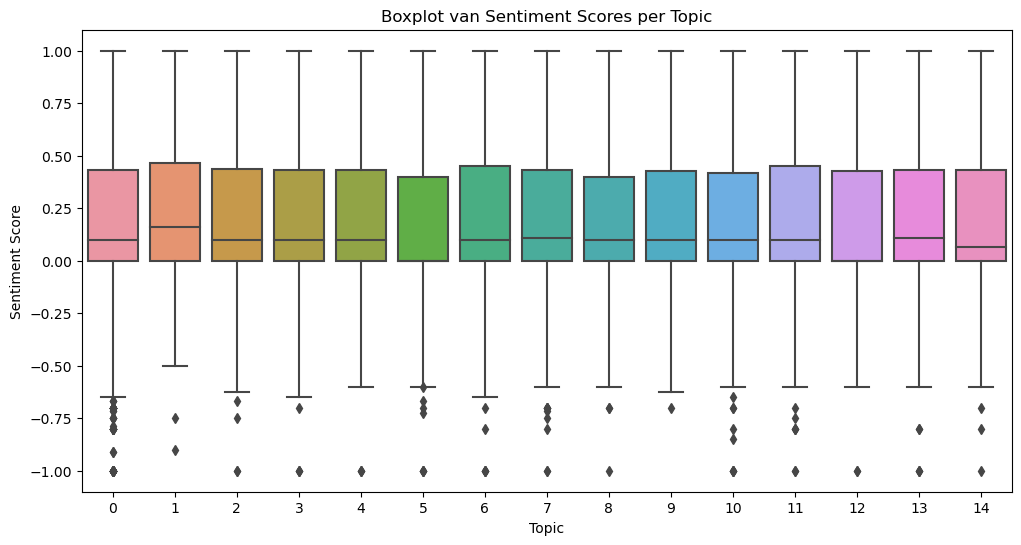

In [216]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='dominant_topic', y='sentiment_score_sentence', data=df)
plt.title('Boxplot van Sentiment Scores per Topic')
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.show()


# Save dataframe

In [168]:
# Assuming 'merged_df' is the DataFrame you want to export
# Export the DataFrame to a CSV file
merged_df.to_csv('/Users/macbook/thesis/new/code/data/processed_data/topics_sentiment.csv', index=False)
